# Importing dependencies

In [1]:
#Importing standard dependencies
import cv2
import os
import random
import numpy as np 
from matplotlib import pyplot as plt

#Importing tensorflow dependencies
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.metrics import Precision, Recall
from tkinter import *
from PIL import Image, ImageTk

2023-05-27 19:20:23.910138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define directories for anchor, negative and positive images
ANC_PATH = os.path.join('images', 'anchor')
NEG_PATH = os.path.join('images', 'negative')
POS_PATH = os.path.join('images', 'positive')

# Define the source directory 
src_dir = 'lfw'

# Setting GPU Growth

In [3]:
# Fetch all physical GPUs in the system
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    # Configuration for allowing TensorFlow to incrementally allocate memory as needed instead of using all GPU memory at startup
    tf.config.experimental.set_memory_growth(gpu, True)


# Creating Folder structures

In [4]:
# Function to create directory if it doesn't exist
def create_directory(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [5]:
# Creates directories for anchor, negative and positive images
create_directory(POS_PATH)
create_directory(NEG_PATH)
create_directory(ANC_PATH)

# Collecting positives and anchors images

In [6]:
# Function to move files from source to destination
def move_files(src_dir, dest_dir):
    # Iterating over each directory in the source directory
    for directory in os.listdir(src_dir):
        directory_path = os.path.join(src_dir, directory)

        # Iterating over each file in the directory
        for file in os.listdir(directory_path):
            src_file_path = os.path.join(directory_path, file)
            dest_file_path = os.path.join(dest_dir, file)

            # Moves the file from source to destination
            os.replace(src_file_path, dest_file_path)


In [7]:
# Moves LFW Images to images/negative directory
move_files(src_dir, NEG_PATH)

In [8]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0, cv2.CAP_AVFOUNDATION)

# Main loop to capture and process frames
while cap.isOpened(): 
    # Capture a frame from the webcam
    ret, frame = cap.read()

    # If the frame was successfully captured
    if ret:
        # Resize the captured frame to 250x250px
        frame = cv2.resize(frame, (250, 250))

        # Display the processed frame in a window
        cv2.imshow('Image Collection', frame)

        # Wait for a key press for 1 millisecond
        key = cv2.waitKey(1) & 0xFF

        # If the 'a' key is pressed, save the current frame as an anchor image
        if key == ord('a'):
            imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
            cv2.imwrite(imgname, frame)

        # If the 'p' key is pressed, save the current frame as a positive image
        if key == ord('p'):
            imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
            cv2.imwrite(imgname, frame)

        # If the 'q' key is pressed, break the loop to stop capturing frames
        if key == ord('q'):
            break

# Release the webcam after the loop ends
cap.release()

# Close the window displaying the frames
cv2.destroyAllWindows()

# Loading and Preprocessing Images

In [9]:
# Define the dataset size
DATASET_SIZE = 300

In [10]:
# Define directories as constants for easy modifications
ANC_PATH = str(ANC_PATH)
POS_PATH = str(POS_PATH)
NEG_PATH = str(NEG_PATH)

In [11]:
# Define a function to create a dataset from a given path
def create_dataset(path):
    return tf.data.Dataset.list_files(path + '/*.jpg').take(DATASET_SIZE)


In [12]:
# Use the function to create datasets for anchor, positive, and negative images
anchor = create_dataset(ANC_PATH)
positive = create_dataset(POS_PATH)
negative = create_dataset(NEG_PATH)

2023-05-27 19:20:35.199671: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Function to preprocess the images by resizing and scaling the image so that it is between 0 and 1
def preprocess(file_path):
    img = tf.image.decode_jpeg(tf.io.read_file(file_path))
    
    # Resize the image to be 100x100x3
    img = tf.image.resize(img, (100,100))  
    
    # Scale image to be between 0 and 1
    return img / 255.0  


In [14]:
# Label the datasets: 1 for positive pair, 0 for negative pair
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))#changed
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))#changed

In [15]:
# Concatenate the labeled datasets
data = positives.concatenate(negatives)

In [16]:
# Preprocess all images in the dataset
data = data.map(lambda anchor, img, label: (preprocess(anchor), preprocess(img), label))

In [17]:
# Define partition sizes
TRAIN_SIZE = round(DATASET_SIZE * .7)
TEST_SIZE = round(DATASET_SIZE * .3) 

In [18]:
# Define a function to create train/test datasets with batching and prefetching
def partition_dataset(dataset, size, skip=0):
    return dataset.skip(skip).take(size).batch(16).prefetch(8)


In [19]:
# Create training, validation, and testing partitions
train_data = partition_dataset(data, TRAIN_SIZE)
test_data = partition_dataset(data, TEST_SIZE, skip=TRAIN_SIZE)

# Model Enginnering


In [20]:
#Building embedding layer
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [21]:
embedding = make_embedding()

In [22]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [23]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [24]:
#Making Siamese Model
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [25]:
siamese_model = make_siamese_model()

# Training Network

In [26]:
#Setting up loss
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [27]:
#Setting up optimizer
opt = tf.keras.optimizers.Adam(1e-4)

In [28]:
#Establishing checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [32]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [33]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [34]:
#Train the model
EPOCHS = 50

In [35]:
train(train_data, EPOCHS)



 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
14/14 [==============================] - 41s 3s/step
1.1281176 1.0 0.8238095

 Epoch 2/50
14/14 [==============================] - 40s 3s/step
1.0116311 1.0 0.8277512

 Epoch 3/50
14/14 [==============================] - 40s 3s/step
0.8661697 0.99421966 0.84729064

 Epoch 4/50
14/14 [==============================] - 40s 3s/step
1.341722 0.99421966 0.8309179

 Epoch 5/50
14/14 [==============================] - 40s 3s/step
1.3241398 0.99421966 0.8911917

 Epoch 6/50
14/14 [==============================] - 40s 3s/step
0.40463758 0.97109824 0.9081081

 Epoch 7/50
14/14 [==============================] - 40s 3s/step
0.21220231 0.9537572 0.9939759

 Epoch 8/50
14/14 [==============================] - 41s 3s/step
0.003410607 0.9884393 0.98275864

 Epoch 9/50
14/14 [==============================] - 40s 3s/step
0.08467317 1.0 

14/14 [==============================] - 41s 3s/step
0.0 1.0 1.0

 Epoch 21/50
14/14 [==============================] - 42s 3s/step
2.8610311e-06 1.0 1.0

 Epoch 22/50
14/14 [==============================] - 41s 3s/step
0.0 1.0 1.0

 Epoch 23/50
14/14 [==============================] - 45s 3s/step
1.1026872e-06 1.0 1.0

 Epoch 24/50
14/14 [==============================] - 41s 3s/step
0.0 1.0 1.0

 Epoch 25/50
14/14 [==============================] - 45s 3s/step
3.635895e-06 1.0 1.0

 Epoch 26/50
14/14 [==============================] - 46s 3s/step
0.0 1.0 1.0

 Epoch 27/50
14/14 [==============================] - 43s 3s/step
1.5586797e-05 1.0 1.0

 Epoch 28/50
14/14 [==============================] - 44s 3s/step
0.0 1.0 1.0

 Epoch 29/50
14/14 [==============================] - 42s 3s/step
3.2782566e-07 1.0 1.0

 Epoch 30/50
14/14 [==============================] - 41s 3s/step
0.0034211227 1.0 1.0

 Epoch 31/50
14/14 [==============================] - 45s 3s/step
0.0 1.0 1.0

 Epoch 

14/14 [==============================] - 40s 3s/step
0.000466624 1.0 1.0

 Epoch 41/50
14/14 [==============================] - 42s 3s/step
0.0 1.0 1.0

 Epoch 42/50
14/14 [==============================] - 42s 3s/step
1.1334 1.0 0.8238095

 Epoch 43/50
14/14 [==============================] - 41s 3s/step
0.7199947 1.0 0.8238095

 Epoch 44/50
14/14 [==============================] - 41s 3s/step
0.69770634 1.0 0.8238095

 Epoch 45/50
14/14 [==============================] - 43s 3s/step
0.698244 1.0 0.8238095

 Epoch 46/50
14/14 [==============================] - 44s 3s/step
0.6994487 1.0 0.8238095

 Epoch 47/50
14/14 [==============================] - 41s 3s/step
0.70024705 1.0 0.8238095

 Epoch 48/50
14/14 [==============================] - 43s 3s/step
0.7007978 1.0 0.8238095

 Epoch 49/50
14/14 [==============================] - 41s 3s/step
0.70174503 1.0 0.8238095

 Epoch 50/50
14/14 [==============================] - 41s 3s/step
0.7022324 1.0 0.8238095


# Evaluating the Model

In [36]:
#Getting a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [37]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 740ms/step


In [38]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [39]:
y_true

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [40]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.0

In [41]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.0

In [42]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 397ms/step
0.0 0.0


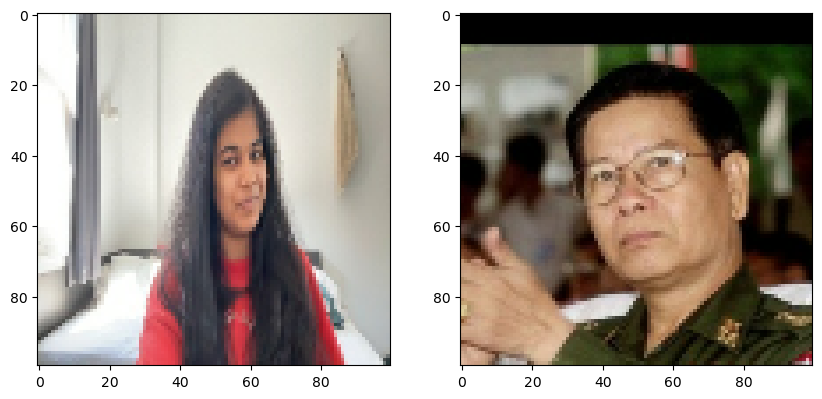

In [43]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[5])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[5])

# Renders cleanly
plt.show()

# Saving the Model

In [44]:
#Saving weights
siamese_model.save('siamesemodel.h5')

In [45]:
#Reload the model
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist' : L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [46]:
#Making predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 0s 460ms/step


array([[0.50436866],
       [0.5044341 ],
       [0.5042923 ],
       [0.50446975],
       [0.50439763],
       [0.5043719 ],
       [0.5043811 ],
       [0.5044396 ],
       [0.50449073],
       [0.5044385 ]], dtype=float32)

In [47]:
#Viewing model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Real time test

## Verification Function

In [48]:
os.listdir(os.path.join('application_data', 'verification_images'))

['db3b66ec-df80-11ed-a277-16ececac2cee.jpg',
 'ede5c378-df80-11ed-a277-16ececac2cee.jpg',
 'da896e74-df80-11ed-a277-16ececac2cee.jpg',
 'da3cebf8-df80-11ed-a277-16ececac2cee.jpg',
 'ec9af128-df80-11ed-a277-16ececac2cee.jpg',
 'e164a344-df80-11ed-a277-16ececac2cee.jpg',
 'e3e67110-df80-11ed-a277-16ececac2cee.jpg',
 'e3cc882c-df80-11ed-a277-16ececac2cee.jpg',
 'ed9907cc-df80-11ed-a277-16ececac2cee.jpg',
 'edb25952-df80-11ed-a277-16ececac2cee.jpg',
 'dabbad44-df80-11ed-a277-16ececac2cee.jpg',
 'e2e87cea-df80-11ed-a277-16ececac2cee.jpg',
 'ed3333d4-df80-11ed-a277-16ececac2cee.jpg',
 'e4c69916-df80-11ed-a277-16ececac2cee.jpg',
 'e2fccea2-df80-11ed-a277-16ececac2cee.jpg',
 'e197daa2-df80-11ed-a277-16ececac2cee.jpg',
 'ed677ea0-df80-11ed-a277-16ececac2cee.jpg',
 'eaef72c2-df80-11ed-a277-16ececac2cee.jpg',
 'e4cb7f8a-df80-11ed-a277-16ececac2cee.jpg',
 'e1fe4364-df80-11ed-a277-16ececac2cee.jpg',
 'e3e0ed44-df80-11ed-a277-16ececac2cee.jpg',
 'eccdf730-df80-11ed-a277-16ececac2cee.jpg',
 'ebe8a6e4

In [49]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [50]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/db3b66ec-df80-11ed-a277-16ececac2cee.jpg
application_data/verification_images/ede5c378-df80-11ed-a277-16ececac2cee.jpg
application_data/verification_images/da896e74-df80-11ed-a277-16ececac2cee.jpg
application_data/verification_images/da3cebf8-df80-11ed-a277-16ececac2cee.jpg
application_data/verification_images/ec9af128-df80-11ed-a277-16ececac2cee.jpg
application_data/verification_images/e164a344-df80-11ed-a277-16ececac2cee.jpg
application_data/verification_images/e3e67110-df80-11ed-a277-16ececac2cee.jpg
application_data/verification_images/e3cc882c-df80-11ed-a277-16ececac2cee.jpg
application_data/verification_images/ed9907cc-df80-11ed-a277-16ececac2cee.jpg
application_data/verification_images/edb25952-df80-11ed-a277-16ececac2cee.jpg
application_data/verification_images/dabbad44-df80-11ed-a277-16ececac2cee.jpg
application_data/verification_images/e2e87cea-df80-11ed-a277-16ececac2cee.jpg
application_data/verification_images/ed3333d4-df80-11ed-a277-16e

In [51]:
def verify(model, detection_threshold, verification_threshold):
   
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
       
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    detection = np.sum(np.array(results) > detection_threshold)
    
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## OpenCV Real Time Verification

In [52]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[ :]
    frame = cv2.resize(frame, (250, 250), interpolation=cv2.INTER_LINEAR)
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

[ WARN:0@3500.802] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


1/1 [==============================] - 0s 129ms/step
True


In [53]:
results

[array([[0.5046224]], dtype=float32),
 array([[0.50462055]], dtype=float32),
 array([[0.5046224]], dtype=float32),
 array([[0.5046182]], dtype=float32),
 array([[0.5046167]], dtype=float32),
 array([[0.50462544]], dtype=float32),
 array([[0.5046215]], dtype=float32),
 array([[0.5046223]], dtype=float32),
 array([[0.504621]], dtype=float32),
 array([[0.5046197]], dtype=float32),
 array([[0.5046214]], dtype=float32),
 array([[0.504619]], dtype=float32),
 array([[0.50462115]], dtype=float32),
 array([[0.5046214]], dtype=float32),
 array([[0.504619]], dtype=float32),
 array([[0.5046253]], dtype=float32),
 array([[0.50462323]], dtype=float32),
 array([[0.5046252]], dtype=float32),
 array([[0.50462055]], dtype=float32),
 array([[0.5046231]], dtype=float32),
 array([[0.5046223]], dtype=float32),
 array([[0.5046161]], dtype=float32),
 array([[0.50461996]], dtype=float32),
 array([[0.50461924]], dtype=float32),
 array([[0.5046187]], dtype=float32),
 array([[0.5046223]], dtype=float32),
 array([